In [271]:
import skimage
import os
from cellpose import models
import numpy as np
from aicsimageio import AICSImage
import napari
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import apoc
from IPython.display import clear_output
from scipy.spatial import distance
scen_channel = 0
marker_channel = 1
nuclei_channel = 2

#padding to extract around each scenescent cell
x_pad = 50
y_pad = 50

#3D classifier
cl3D_filename = 'models/scen_3D.cl'

In [284]:

def ExtractSingleObject(image, centroid, x_pad = 50, y_pad = 50):
    cy = int(centroid[0])
    cx = int(centroid[1])

    subset_im = np.copy(image[cy-y_pad:cy+y_pad, cx-x_pad:cx+x_pad])
    return subset_im

def ExtractSingleObject3D(image, centroid, x_pad = 50, y_pad = 50):
    cy = int(centroid[0])
    cx = int(centroid[1])
    subset_im = np.copy(image[:, cy-y_pad:cy+y_pad, cx-x_pad:cx+x_pad])
    return subset_im

def filter_classified_image(im, lower_bound, upper_bound):
    '''takes a  label image, an upper and lower size bound and returns a labeled image conatining only the objects within that size bound'''
    props = skimage.measure.regionprops(im)
    for prop in tqdm(props, desc="Filtering senescent cell regions"):
        if prop['area'] < (lower_bound):
            im[im == prop['label']] = 0
        if prop['area'] > (upper_bound):
            im[im == prop['label']] = 0

    return im

def match_nuclei_3D():
    print('implement')

def MatchNuclei(scen_mask_im, nuc_mask_im):
    props_scen = skimage.measure.regionprops(scen_mask_im)
    scen_labels_updated = np.copy(scen_mask_im)
    scen_labels_matched = np.zeros(scen_mask_im.shape, dtype=np.uint16)
    matching_nuclei = np.zeros(nuc_mask_im.shape, dtype=np.uint16)
    
    for i, prop in enumerate(tqdm(props_scen, desc="Matching nuclei to senescent cell masks")): 

        num_nuc = 0  #keep track of the number of nuclei per senescent cell
        matched_nuc_val = -1   #keep track of the matching nuclear value
        
        single_scen_im = ExtractSingleObject(scen_mask_im, prop['centroid'])
        single_scen_im[single_scen_im != prop['label']] = 0

        single_nuc_im = ExtractSingleObject(nuc_mask_im, prop['centroid'])
        matched_nuclei = np.copy(single_nuc_im)

        matched_nuclei[single_scen_im != prop['label']] = 0
        unique, counts = np.unique(matched_nuclei, return_counts=True)
        
        max_count = 0
        max_nuc = -1
        for unique, count in zip(unique, counts):
            if unique > 0:
                if count > max_count:
                    max_count = count     
                    max_nuc = unique

            if max_nuc > -1:
                nuc_total_area = np.count_nonzero(nuc_mask_im[nuc_mask_im == max_nuc])
                overlap = max_count / nuc_total_area * 100
                if overlap > 80:
                    matching_nuclei[nuc_mask_im == max_nuc] = max_nuc
                    scen_labels_updated[scen_mask_im == prop['label']] = 0
                    scen_labels_matched[scen_mask_im == prop['label']] = prop['label']
    return matching_nuclei, scen_labels_updated, scen_labels_matched

def MakeChullImage(lab_im):
    chull_image = np.zeros(lab_im.shape)
    props = skimage.measure.regionprops(lab_im)

    for prop in tqdm(props, desc="Calculating convex hull image"):
        temp = np.zeros(lab_im.shape)
        subset_im = ExtractSingleObject(lab_im, prop['centroid'])
        subset_im[subset_im != prop['label']] = 0
        cy = int(prop['centroid'][0])
        cx = int(prop['centroid'][1])
        chull = skimage.morphology.convex_hull_image(subset_im)
        try:        
            temp[cy-150:cy+150, cx-150:cx+150] = chull
            chull_image[temp > 0] = prop['label']
        except:
            print('chull failed')
    return chull_image.astype(np.uint16)

def find_max_overlap(nuc_mask_subset, clean_scen_labs):
    '''takes a celpose classified 3D nuclear mask image, and a scenescent label image with a single 
    label, and finds the corresponding nucleus based on maximum overlap
    returns nucleus label, nucleus centroid and overlap amount
    '''
    nuc_props = skimage.measure.regionprops(nuc_mask_subset)
    max_overlap = 0
    max_lab = - 1
    nuc_centroid = -1
    for nuc_prop in nuc_props:
        overlap = np.count_nonzero(clean_scen_labs[nuc_mask_subset == nuc_prop['label']])
        if overlap > max_overlap:
            max_overlap = overlap
            max_lab = nuc_prop['label']
            nuc_centroid = nuc_prop['centroid']
    return max_lab, nuc_centroid, max_overlap


def find_scenescent_cell_closest_to_center(scen_subset, min_area, x_pad=x_pad, y_pad=y_pad):
    '''takes a scenescent cell classified subset, a miniumum area, and the padding values and returns
    an image containing only the label closest to the center'''
    labs = skimage.measure.label(scen_subset)
    props = skimage.measure.regionprops(labs)
    min_dist = 9999
    min_prop = -1
    for prop in props:
        if prop['label'] > 1:       #do not include background lab
            if prop['area'] > min_area:
                centroid = (prop['centroid'][1], prop['centroid'][2])
                dist =  distance.euclidean(centroid, (x_pad,y_pad))
                if dist < min_dist:
                    min_dist = dist
                    min_prop = prop['label']
    if min_prop > 0:
        labs[labs != min_prop] = 0
    return labs

def classify_3D_crop(crop, erosion_num):
    '''takes a 3D crop and applies the 3D classifier
    dilates and erodes a set number of times (default = 4)
    returns the classified and dilated/eroded image'''

    clf = apoc.PixelClassifier(opencl_filename=cl3D_filename)
    result = clf.predict(image=crop)

    result_eroded = np.copy(result)
    for k in range(0, erosion_num):
        result_eroded = skimage.morphology.dilation(result_eroded)
    for k in range(0, erosion_num):
        result_eroded = skimage.morphology.erosion(result_eroded)

    return result_eroded

def find_matching_nucleus(nuc_centroid, nuc_crops_2D):
    nuc_props_2D = skimage.measure.regionprops(nuc_crops_2D)
    min_dist = 999999
    for prop in nuc_props_2D:
        dist =  distance.euclidean((nuc_centroid[1], nuc_centroid[2]), prop['centroid'])
        if dist < min_dist:
            min_dist = dist
            min_prop = prop['label']
    return min_prop, min_dist

In [68]:
outout_folder = 'output'
raw_data_folder = os.path.join('..', '..', 'AI4Life - Ana Filipa Pombinho Isidro', 'AI4Life', 'B', 'raw' )
files = os.listdir(raw_data_folder)



In [ ]:
##replace with labkit segmentation using Nuno's script
for file in files:
    print('classifying file ' + file)
    img = AICSImage(raw_data_folder + os.path.sep + file)
    im = img.data[0,:,:,:,:]

    im_to_classify = np.amax(im[scen_channel, :, :], axis=0)

    cl_filename = 'models/my_model.cl'
    clf = apoc.PixelClassifier(opencl_filename=cl_filename)

    result = clf.predict(image=im_to_classify)
    result_dil = skimage.morphology.erosion(result)
    result_dil = skimage.morphology.erosion(result)
    result_dil = skimage.morphology.erosion(result)
    result_dil = skimage.morphology.dilation(result)

    skimage.io.imsave(outout_folder + os.path.sep + '2D_class' + os.path.sep + file[:-4] + '.tif', result_dil, check_contrast=False)

In [ ]:
#cellpose segment
for file in files:
    print('cellpose segmenting file ' + file)
    img = AICSImage(raw_data_folder + os.path.sep + file)
    im = img.data[0,:,:,:,:]
    im_to_segment = np.amax(im[nuclei_channel, :, :], axis=0)
    model = models.Cellpose(model_type='cyto2')
    channels = [[0,0]]
    nuclear_masks, flows, styles, diams = model.eval(im_to_segment, diameter=20, flow_threshold=None)
    skimage.io.imsave(outout_folder + os.path.sep + 'nuclei' + os.path.sep + file[:-4] + '.tif', nuclear_masks, check_contrast=False)

In [185]:
#TEMP: reload the data
filenum = 0
filename = files[filenum][:-4]
print("Loading filename: " + filename)
im = AICSImage(raw_data_folder + os.path.sep + filename + '.czi')
raw_im = im.data[0,:,:,:,:]
classified_im = skimage.io.imread(outout_folder + os.path.sep + '2D_class' + os.path.sep + 'classified_' + filename + '.tif')
nuclei_im = skimage.io.imread(outout_folder + os.path.sep + 'nuclei' + os.path.sep + filename + '.tif')



Loading filename: Image3_B


In [186]:
#erode the scenescent masks

eroded_lab_image = np.copy(classified_im)
print(np.count_nonzero(eroded_lab_image))
dilated = skimage.morphology.erosion(eroded_lab_image)
for i in range(0, 4):
    eroded_lab_image = skimage.morphology.erosion(eroded_lab_image)
print(np.count_nonzero(eroded_lab_image))
for i in range(0, 4):
    eroded_lab_image = skimage.morphology.dilation(eroded_lab_image)

print(np.count_nonzero(eroded_lab_image))

72335
23769
60870


In [222]:
#filter the classified objects

nuc_labs = skimage.measure.label(nuclei_im)
classified_labs = skimage.measure.label(eroded_lab_image)

#calculate the minimum, mean, and maximum nuclear area
areas = []
all_nuc_props = skimage.measure.regionprops(nuc_labs)
for nuc_prop in tqdm(all_nuc_props, desc="Measuring nuclei"):
    areas.append(nuc_prop['area'])
mean_nuc_area = np.mean(areas)
max_nuc_area = np.max(areas)
min_nuc_area = np.min(areas)

filtered_lab_image = filter_classified_image(classified_labs, mean_nuc_area * 2, max_nuc_area * 30)




Measuring nuclei:   0%|          | 0/5673 [00:00<?, ?it/s]

Filtering senescent cell regions:   0%|          | 0/212 [00:00<?, ?it/s]

35130
16411
32566


In [265]:
#loop through and extract 3D volumes around each centroid

crops = []
nuc_crops = []
centroids = []
nuc_crops_2D = []

scenescent_props = skimage.measure.regionprops(filtered_lab_image)
for prop in tqdm(scenescent_props):
    crop_3D = ExtractSingleObject3D(raw_im[scen_channel,:,:,:], prop['centroid'], x_pad, y_pad)
    nuc_crop_3D = ExtractSingleObject3D(raw_im[nuclei_channel,:,:,:], prop['centroid'], x_pad, y_pad)
    nuc_crop_2D = ExtractSingleObject(nuclei_im, prop['centroid'], x_pad, y_pad)
    centroids.append(prop['centroid'])
    crops.append(crop_3D)
    nuc_crops.append(nuc_crop_3D)
    nuc_crops_2D.append(nuc_crop_2D)

  0%|          | 0/31 [00:00<?, ?it/s]

<Labels layer 'classified_im' at 0x7fcd9032ad90>

In [280]:
#loop through all cells in an image


model = models.Cellpose(model_type='cyto2')


for crop, cropnum in tqdm(enumerate(crops)):

    #classify the 3D crop
    result_eroded = classify_3D_crop(single_crop, 4)
    #remove labs not near center
    labs = find_scenescent_cell_closest_to_center(result_eroded, 100, x_pad, y_pad)
    #cellpose segment the crops
    nuc_mask_subset, flows, styles, diams = model.eval(nuc_crops[cropnum], diameter=20, flow_threshold=None, do_3D=True)
    #find the nucleus with the maxium overlap
    max_lab, nuc_centroid, max_overlap = find_max_overlap(nuc_mask_subset, labs)
    #find the matching nucleus in the 2D classification
    min_prop, min_dist = find_matching_nucleus(nuc_centroid, nuc_crops_2D[cropnum])


In [281]:
viewer = napari.Viewer()
viewer.add_image(crops[cropnum])

viewer.add_labels(result_eroded)

<Labels layer 'result_eroded' at 0x7fcd571c4a90>

In [269]:
viewer = napari.Viewer()
viewer.add_labels(labs)

<Labels layer 'labs' at 0x7fcd6bc493a0>

In [253]:
nuc_crops_2D[0].shape

(100, 100)

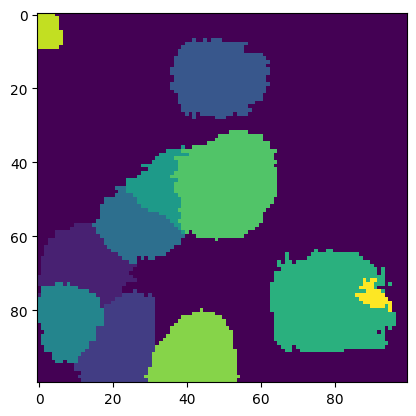

In [255]:
plt.imshow(np.amax(nuc_mask_subset, axis=0))

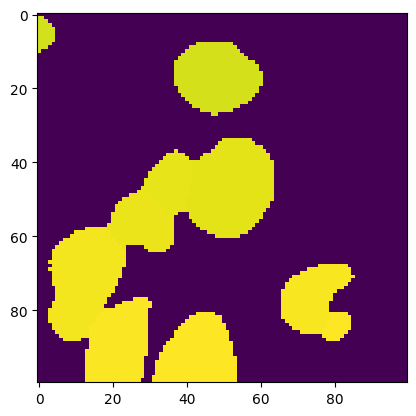

In [256]:
plt.imshow(nuc_crops_2D[cropnum])


In [258]:
blank_nuclei = np.zeros_like(nuclei_im)
blank_nuclei[nuclei_im == min_prop] = min_prop

In [259]:
viewer = napari.Viewer()
viewer.add_image(np.amax(raw_im[scen_channel,:,:,:], axis=0))
viewer.add_labels(filtered_lab_image)
viewer.add_labels(classified_im)
viewer.add_labels(blank_nuclei)
viewer.add_labels(nuclei_im)



<Labels layer 'nuclei_im' at 0x7fcd6aaaaee0>

In [215]:
viewer = napari.Viewer()
#viewer.add_image(crops[cropnum], blending="additive", colormap='green')
#viewer.add_image(nuc_crops[cropnum], blending="additive", colormap='red')
viewer.add_labels(nuc_mask_subset)
#viewer.add_labels(result)
#viewer.add_labels(result_eroded)

viewer.add_labels(labs)


<Labels layer 'labs' at 0x7fcd72041970>

In [3]:
path = '../3D_for_apoc/raw/'
savepath = '../3D_for_apoc/labs/'
ims = os.listdir(path)


In [12]:
cl_filename = 'scen_3D.cl'

clf = apoc.PixelClassifier(opencl_filename=cl_filename)

In [21]:
viewer.add_image(test_im)

<Image layer 'test_im' at 0x1a6f55170a0>

In [20]:
test_im = dapi_norm[800:1100, 800:1100]

In [ ]:
#classify an individual file
cl_filename = 'my_model.cl'
clf = apoc.PixelClassifier(opencl_filename=cl_filename)

model = models.Cellpose(model_type='cyto2')
channels = [[0,0]]
files = os.listdir(raw_data_location)

In [4]:
raw_data_path = os.path.join('..', '..', 'AI4Life - Ana Filipa Pombinho Isidro', 'AI4Life', 'B', 'raw' )
classified_images_path = os.path.join('..', 'labkit_segmentation', 'classified')
output_data_path =  os.path.join('..', 'output')
raw_files = sorted(os.listdir(raw_data_path))
classified_files = sorted(os.listdir(classified_images_path))


for raw, classified in zip(raw_files, classified_files):
    print(raw, classified)



Image1_B.czi classified_Image1_B.tif
Image2_B.czi classified_Image2_B.tif
Image3_B.czi classified_Image3_B.tif
Image4_B.czi classified_Image4_B.tif
Image5_B.czi classified_Image5_B.tif
Image6_B.czi classified_Image6_B.tif


In [5]:
rawim =  img = AICSImage(raw_data_path + os.path.sep + raw_files[0])

In [6]:
rawim.shape

(1, 3, 25, 3789, 4710)

In [54]:
#extract a 3D subset for further classification
#also get nuclei

##TODO: see how long it takes cellpose to do slice by slice segmentation
#looks OK, let's see what it looks like on actual data with a segmented mask! :)


#cellpose this one: subset_3D_ch2

subset_3D_ch0 = ExtractSingleObject3D(rawim.data[0,0,:,:,:], (2000, 2000))
subset_3D_ch1 = ExtractSingleObject3D(rawim.data[0,1,:,:,:], (2000, 2000))
subset_3D_ch2 = ExtractSingleObject3D(rawim.data[0,2,:,:,:], (2000, 2000))


In [70]:
seg2D = []

for i in tqdm(range(0, subset_3D_ch2.shape[0])):
    nuclear_masks, flows, styles, diams = model.eval(subset_3D_ch2[i,:,:], diameter=20, flow_threshold=None)
    seg2D.append(nuclear_masks)

  0%|          | 0/25 [00:00<?, ?it/s]

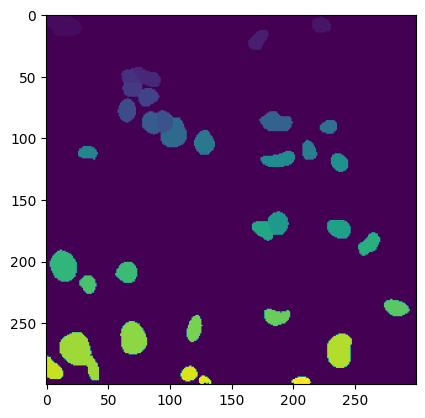

In [75]:
plt.imshow(seg2D[9])

In [65]:

nuclear_masks, flows, styles, diams = model.eval(subset_3D_ch2, diameter=20, flow_threshold=None, do_3D=True)
    

In [64]:
nuclear_masks.shape

(25, 300)

In [66]:
viewer2 = napari.Viewer()
viewer2.add_image(subset_3D_ch0)
viewer2.add_image(subset_3D_ch1)
viewer2.add_image(subset_3D_ch2)
viewer2.add_labels(nuclear_masks)


<Labels layer 'nuclear_masks' at 0x1a70e3cd3a0>

In [7]:
model = models.Cellpose(model_type='cyto2')
channels = [[0,0]]


output_data_path =  os.path.join('..', 'output_3D')

for i, file in enumerate(tqdm(raw_files)):
    if i == 4:
        print(file)
        img = AICSImage(raw_data_path + os.path.sep + file)
        img = img.data
        scen_classified = skimage.io.imread(classified_images_path + os.path.sep + classified_files[i])
        sum_proj = np.sum(img, axis=2)
        DAPI = sum_proj[0,2,:,:]
        scen_marker = sum_proj[0,0,:,:]
        dapi_norm = (DAPI - np.min(DAPI)) / (np.max(DAPI) - np.min(DAPI))


        #load instead
        #nuclear_masks, flows, styles, diams = model.eval(dapi_norm, diameter=20, flow_threshold=None, channels=channels)
        nuclear_masks = skimage.io.imread(output_data_path + os.path.sep + file + os.path.sep + 'all_nuclei.tif')

        props = skimage.measure.regionprops(nuclear_masks)

        areas = []
        for prop in tqdm(props, desc="Measuring nuclei"):
            areas.append(prop['area'])

        mean_nuc_area = np.mean(areas)
        max_nuc_area = np.max(areas)
        min_nuc_area = np.min(areas)

        labs = skimage.measure.label(scen_classified)

        labs_filtered = np.copy(labs)
        props = skimage.measure.regionprops(labs)

        for prop in tqdm(props, desc="Filtering senescent cell regions"):
            if prop['area'] < (mean_nuc_area):
                labs_filtered[labs_filtered == prop['label']] = 0
            if prop['area'] > (mean_nuc_area*30):
                labs_filtered[labs_filtered == prop['label']] = 0

        matching_nuclei, scen_labels_updated, scen_labels_matched = MatchNuclei(labs_filtered, nuclear_masks)
        chull_im = MakeChullImage(scen_labels_updated)

        matching_nuclei_chull, scen_labels_updated_chull, scen_labels_matched_chull = MatchNuclei(chull_im, nuclear_masks)


        all_matched_nuclei = np.zeros(labs_filtered.shape, dtype=np.uint16)
        props = skimage.measure.regionprops(matching_nuclei)
        for prop in tqdm(props):
            all_matched_nuclei[matching_nuclei == prop['label']] = prop['label']
        props = skimage.measure.regionprops(matching_nuclei_chull)
        for prop in tqdm(props):
            all_matched_nuclei[matching_nuclei_chull == prop['label']] = prop['label']

        nuc_bin = np.zeros(all_matched_nuclei.shape, dtype=np.uint16)
        nuc_bin[all_matched_nuclei > 0 ] = 100
        all_nuc_bin = np.zeros(all_matched_nuclei.shape, dtype=np.uint16)
        all_nuc_bin[nuclear_masks > 0 ] = 100

        os.makedirs(output_data_path + os.path.sep + file)

        skimage.io.imsave(output_data_path + os.path.sep + file + os.path.sep + 'all_matched_nuclei.tif', nuc_bin)
        skimage.io.imsave(output_data_path + os.path.sep + file + os.path.sep + 'scen_marker.tif', scen_marker.astype(np.uint16))
        skimage.io.imsave(output_data_path + os.path.sep + file + os.path.sep + 'all_nuclei.tif', all_nuc_bin)
        clear_output(wait=True)

  0%|          | 0/6 [00:00<?, ?it/s]

Image5_B.czi


FileNotFoundError: [Errno 2] No such file or directory: '/facility/imganfac/AI4Life/47_senescence/working/output_3D/Image5_B.czi/all_nuclei.tif'

In [67]:
nuclear_masks.shape

(3788, 4710)

In [10]:
v = napari.Viewer()
v.add_image(scen_marker)
v.add_labels(nuc_bin)
v.add_labels(all_nuc_bin)



<Labels layer 'all_nuc_bin' at 0x1a67f45e070>

In [11]:
v.add_labels(scen_classified)

<Labels layer 'scen_classified' at 0x1a680954850>

In [62]:
#measure the marker based on the nuclei

folders = os.listdir(output_data_path)

mask_paths = []
raw_paths = []
rawims = []

for folder in folders:
    rawims.append(folder)
    files = os.listdir(output_data_path + os.path.sep + folder)
    mask_paths.append(output_data_path + os.path.sep + folder + os.path.sep + files[0])    
    raw_paths.append(output_data_path + os.path.sep + folder + os.path.sep + files[3])    


# for raw_path, mask_path in zip(raw_paths, mask_paths):
#     mask_im = skimage.io.imread(mask_path)
#     raw_im = skimage.io.imread(raw_path)
#     marker = raw_im[0,:,:,1]
#     senescent_intensities = []

#     labs = skimage.measure.label(mask_im)
#     props = skimage.measure.regionprops(labs)
#     for prop in props:
#         mean = np.mean(marker[labs == prop['label']])
#         senescent_intensities.append(mean)

#     df = pd.DataFrame()
#     df['senescent_intensities'] = senescent_intensities
#     df.to_csv(output_data_path + os.path.sep + folder + os.path.sep + 'output.csv')

    


IndexError: boolean index did not match indexed array along dimension 0; dimension is 3788 but corresponding boolean dimension is 3789

In [82]:
raw_data = os.listdir(raw_data_path)
for file in raw_data:
    print(file)
    img = AICSImage(raw_data_path + os.path.sep + file)
    img = img.data
    sum_proj = np.sum(img, axis=2)
    path = os.path.join(output_data_path, file, 'sum_proj.tif')
    print('saving ' + path)
    skimage.io.imsave(path, sum_proj)


Image1_B.czi
saving ..\output\Image1_B.czi\sum_proj.tif


C:\Users\damian.dalle\AppData\Local\Temp\ipykernel_18236\3026749486.py:9: UserWarning: ..\output\Image1_B.czi\sum_proj.tif is a low contrast image
  skimage.io.imsave(path, sum_proj)


Image2_B.czi
saving ..\output\Image2_B.czi\sum_proj.tif


C:\Users\damian.dalle\AppData\Local\Temp\ipykernel_18236\3026749486.py:9: UserWarning: ..\output\Image2_B.czi\sum_proj.tif is a low contrast image
  skimage.io.imsave(path, sum_proj)


Image3_B.czi
saving ..\output\Image3_B.czi\sum_proj.tif


C:\Users\damian.dalle\AppData\Local\Temp\ipykernel_18236\3026749486.py:9: UserWarning: ..\output\Image3_B.czi\sum_proj.tif is a low contrast image
  skimage.io.imsave(path, sum_proj)


Image4_B.czi
saving ..\output\Image4_B.czi\sum_proj.tif


C:\Users\damian.dalle\AppData\Local\Temp\ipykernel_18236\3026749486.py:9: UserWarning: ..\output\Image4_B.czi\sum_proj.tif is a low contrast image
  skimage.io.imsave(path, sum_proj)


Image5_B.czi
saving ..\output\Image5_B.czi\sum_proj.tif


C:\Users\damian.dalle\AppData\Local\Temp\ipykernel_18236\3026749486.py:9: UserWarning: ..\output\Image5_B.czi\sum_proj.tif is a low contrast image
  skimage.io.imsave(path, sum_proj)


Image6_B.czi
saving ..\output\Image6_B.czi\sum_proj.tif


C:\Users\damian.dalle\AppData\Local\Temp\ipykernel_18236\3026749486.py:9: UserWarning: ..\output\Image6_B.czi\sum_proj.tif is a low contrast image
  skimage.io.imsave(path, sum_proj)


In [78]:
path = os.path.join(output_data_path, file, 'sum_proj.tif')
path

'..\\output\\Image6_B.czi\\sum_proj.tif'

In [76]:
img.shape

(1, 3, 25, 3789, 4710)

In [74]:
img = AICSImage(raw_data_path + os.path.sep + raw_data[0])
img = img.data



In [66]:
img.shape

(1, 3, 19, 3788, 4710)

In [45]:
 DAPI = sum_proj[0,2,:,:]

(1, 3788, 4710, 3)

In [55]:
viewer = napari.Viewer()

viewer.add_image(raw_im[:,:,:,0], name="0")
viewer.add_image(raw_im[:,:,:,1], name="1")
viewer.add_image(raw_im[:,:,:,2], name="2")

<Image layer '2' at 0x2051f0ed4f0>